import qiskit
# Imports for Qiskit

import numpy as np

# Various imports 
import numpy as np

from copy import deepcopy
from matplotlib import pyplot as plt
from typing import Optional, Union, List, Callable, Tuple

In [1]:
pip install -U psutil

Note: you may need to restart the kernel to use updated packages.


In [2]:
import qiskit.algorithms
from typing import Optional, Union, List, Callable, Tuple
import numpy as np

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import *
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from qiskit.opflow import (
    Z,
    I,
    StateFn,
    TensoredOp,
    ExpectationBase,
    CircuitSampler,
    ListOp,
    ExpectationFactory,
)
from qiskit.providers import Backend
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.utils import QuantumInstance
from qiskit.utils.deprecation import deprecate_function

from qiskit.algorithms.linear_solvers import LinearSolver, LinearSolverResult
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.algorithms.linear_solvers.observables.linear_system_observable import LinearSystemObservable

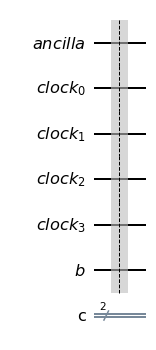

In [3]:
# Initialize State (Psi_0)
clock = QuantumRegister(4, name='clock') # Clock/C Register/A Matrix with 4 bits
b = QuantumRegister(1, name='b') # B Register with 1 bit
ancilla = QuantumRegister(1, name='ancilla') # Ancilla Qubit with 1 bit
measurement = ClassicalRegister(2, name='c')

# Creating an empty circuit with intial state (defined above)
circuit = QuantumCircuit(ancilla, clock, b, measurement)

# Drawing barrier for state zero to make it easy to visualize (dotted line shown)
circuit.barrier()

# Drawing circuit
circuit.draw(output='mpl')

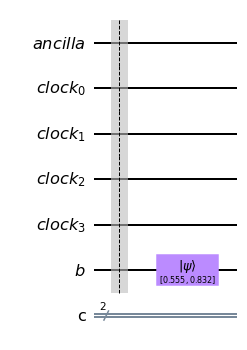

In [4]:
# State preparation. 
intial_state = [2/np.sqrt(13),3/np.sqrt(13)]
circuit.initialize(intial_state, 5) # Initialize state (encode) on the 5th bit

circuit.draw('mpl',scale=1)

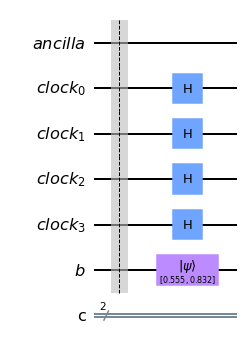

In [5]:
# Applying Hadamard gates to all the clock qubits
circuit.h(clock)
circuit.draw('mpl',scale=1)

In [6]:
A = np.array([[1,4],[4,1]])
b = np.array([2,3]).T

In [7]:
epsilon = 1e-2
# Tolerance for the different parts of the algorithm as per [1]
_epsilon_r = epsilon / 3  # conditioned rotation
_epsilon_s = epsilon / 3  # state preparation
_epsilon_a = epsilon / 6  # hamiltonian simulation

_scaling = None  # scaling of the solution

_sampler = None

#self.quantum_instance = quantum_instance

#self._expectation = expectation

# For now the default reciprocal implementation is exact
_exact_reciprocal = True
# Set the default scaling to 1
scaling = 1

In [8]:
def _get_delta(n_l: int, lambda_min: float, lambda_max: float) -> float:
        """Calculates the scaling factor to represent exactly lambda_min on nl binary digits.

        Args:
            n_l: The number of qubits to represent the eigenvalues.
            lambda_min: the smallest eigenvalue.
            lambda_max: the largest eigenvalue.

        Returns:
            The value of the scaling factor.
        """
        formatstr = "#0" + str(n_l + 2) + "b"
        lambda_min_tilde = np.abs(lambda_min * (2**n_l - 1) / lambda_max)
        # floating point precision can cause problems
        if np.abs(lambda_min_tilde - 1) < 1e-7:
            lambda_min_tilde = 1
        binstr = format(int(lambda_min_tilde), formatstr)[2::]
        lamb_min_rep = 0
        for i, char in enumerate(binstr):
            lamb_min_rep += int(char) / (2 ** (i + 1))
        return lamb_min_rep

In [9]:
def construct_circuit(

        matrix: Union[List, np.ndarray, QuantumCircuit],
        vector: Union[List, np.ndarray, QuantumCircuit],
        neg_vals: Optional[bool] = True,
    ) -> QuantumCircuit:
        """Construct the HHL circuit.

        Args:
            matrix: The matrix specifying the system, i.e. A in Ax=b.
            vector: The vector specifying the right hand side of the equation in Ax=b.
            neg_vals: States whether the matrix has negative eigenvalues. If False the
            computation becomes cheaper.

        Returns:
            The HHL circuit.

        Raises:
            ValueError: If the input is not in the correct format.
            ValueError: If the type of the input matrix is not supported.
        """
        # State preparation circuit - default is qiskit
        if isinstance(vector, QuantumCircuit):
            nb = vector.num_qubits
            vector_circuit = vector
        elif isinstance(vector, (list, np.ndarray)):
            if isinstance(vector, list):
                vector = np.array(vector)
            nb = int(np.log2(len(vector)))
            vector_circuit = QuantumCircuit(nb)
            vector_circuit.isometry(vector / np.linalg.norm(vector), list(range(nb)), None)

        # If state preparation is probabilistic the number of qubit flags should increase
        nf = 1

        # Hamiltonian simulation circuit - default is Trotterization
        if isinstance(matrix, QuantumCircuit):
            matrix_circuit = matrix
        elif isinstance(matrix, (list, np.ndarray)):
            if isinstance(matrix, list):
                matrix = np.array(matrix)

            if matrix.shape[0] != matrix.shape[1]:
                raise ValueError("Input matrix must be square!")
            if np.log2(matrix.shape[0]) % 1 != 0:
                raise ValueError("Input matrix dimension must be 2^n!")
            if not np.allclose(matrix, matrix.conj().T):
                raise ValueError("Input matrix must be hermitian!")
            if matrix.shape[0] != 2**vector_circuit.num_qubits:
                raise ValueError(
                    "Input vector dimension does not match input "
                    "matrix dimension! Vector dimension: "
                    + str(vector_circuit.num_qubits)
                    + ". Matrix dimension: "
                    + str(matrix.shape[0])
                )
            matrix_circuit = NumPyMatrix(matrix, evolution_time=2 * np.pi)
        else:
            raise ValueError(f"Invalid type for matrix: {type(matrix)}.")

        # Set the tolerance for the matrix approximation
        if hasattr(matrix_circuit, "tolerance"):
            matrix_circuit.tolerance = _epsilon_a

        # check if the matrix can calculate the condition number and store the upper bound
        if (
            hasattr(matrix_circuit, "condition_bounds")
            and matrix_circuit.condition_bounds() is not None
        ):
            kappa = matrix_circuit.condition_bounds()[1]
        else:
            kappa = 1
        # Update the number of qubits required to represent the eigenvalues
        # The +neg_vals is to register negative eigenvalues because
        # e^{-2 \pi i \lambda} = e^{2 \pi i (1 - \lambda)}
        nl = max(nb + 1, int(np.ceil(np.log2(kappa + 1)))) + neg_vals

        # check if the matrix can calculate bounds for the eigenvalues
        if hasattr(matrix_circuit, "eigs_bounds") and matrix_circuit.eigs_bounds() is not None:
            lambda_min, lambda_max = matrix_circuit.eigs_bounds()
            # Constant so that the minimum eigenvalue is represented exactly, since it contributes
            # the most to the solution of the system. -1 to take into account the sign qubit
            delta = _get_delta(nl - neg_vals, lambda_min, lambda_max)
            # Update evolution time
            matrix_circuit.evolution_time = 2 * np.pi * delta / lambda_min / (2**neg_vals)
            # Update the scaling of the solution
            scaling = lambda_min
        else:
            delta = 1 / (2**nl)
            print("The solution will be calculated up to a scaling factor.")

        if _exact_reciprocal:
            reciprocal_circuit = ExactReciprocal(nl, delta, neg_vals=neg_vals)
            # Update number of ancilla qubits
            na = matrix_circuit.num_ancillas
        else:
            # Calculate breakpoints for the reciprocal approximation
            num_values = 2**nl
            constant = delta
            a = int(round(num_values ** (2 / 3)))

            # Calculate the degree of the polynomial and the number of intervals
            r = 2 * constant / a + np.sqrt(np.abs(1 - (2 * constant / a) ** 2))
            degree = min(
                nb,
                int(
                    np.log(
                        1
                        + (
                            16.23
                            * np.sqrt(np.log(r) ** 2 + (np.pi / 2) ** 2)
                            * kappa
                            * (2 * kappa - _epsilon_r)
                        )
                        / _epsilon_r
                    )
                ),
            )
            num_intervals = int(np.ceil(np.log((num_values - 1) / a) / np.log(5)))

            # Calculate breakpoints and polynomials
            breakpoints = []
            for i in range(0, num_intervals):
                # Add the breakpoint to the list
                breakpoints.append(a * (5**i))

                # Define the right breakpoint of the interval
                if i == num_intervals - 1:
                    breakpoints.append(num_values - 1)

            reciprocal_circuit = PiecewiseChebyshev(
                lambda x: np.arcsin(constant / x), degree, breakpoints, nl
            )
            na = max(matrix_circuit.num_ancillas, reciprocal_circuit.num_ancillas)

        # Initialise the quantum registers
        qb = QuantumRegister(nb)  # right hand side and solution
        ql = QuantumRegister(nl)  # eigenvalue evaluation qubits
        if na > 0:
            qa = AncillaRegister(na)  # ancilla qubits
        qf = QuantumRegister(nf)  # flag qubits

        if na > 0:
            qc = QuantumCircuit(qb, ql, qa, qf)
        else:
            qc = QuantumCircuit(qb, ql, qf)

        # State preparation
        qc.append(vector_circuit, qb[:])
        # QPE
        phase_estimation = PhaseEstimation(nl, matrix_circuit)
        if na > 0:
            qc.append(phase_estimation, ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
        else:
            qc.append(phase_estimation, ql[:] + qb[:])
        # Conditioned rotation
        if _exact_reciprocal:
            qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])
        else:
            qc.append(
                reciprocal_circuit.to_instruction(),
                ql[:] + [qf[0]] + qa[: reciprocal_circuit.num_ancillas],
            )
        # QPE inverse
        if na > 0:
            qc.append(phase_estimation.inverse(), ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
        else:
            qc.append(phase_estimation.inverse(), ql[:] + qb[:])
        return qc

In [10]:
bruh = construct_circuit(A, b, True)

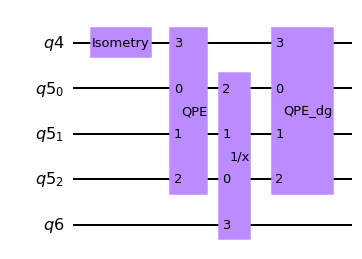

In [13]:
bruh.decompose().draw('mpl',scale=1)

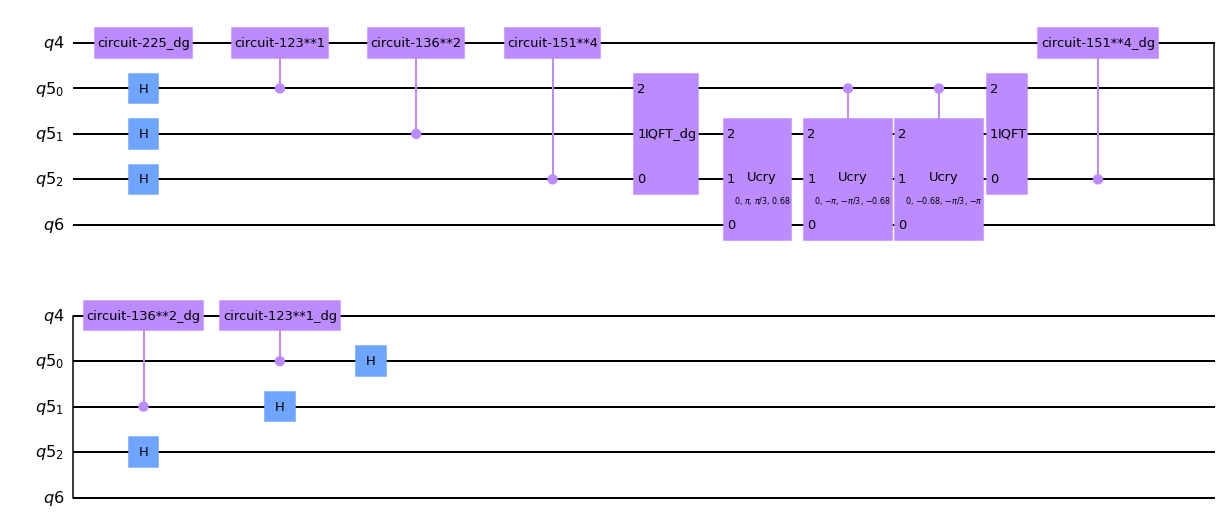

In [14]:
bruh.decompose().decompose().draw('mpl',scale=1)

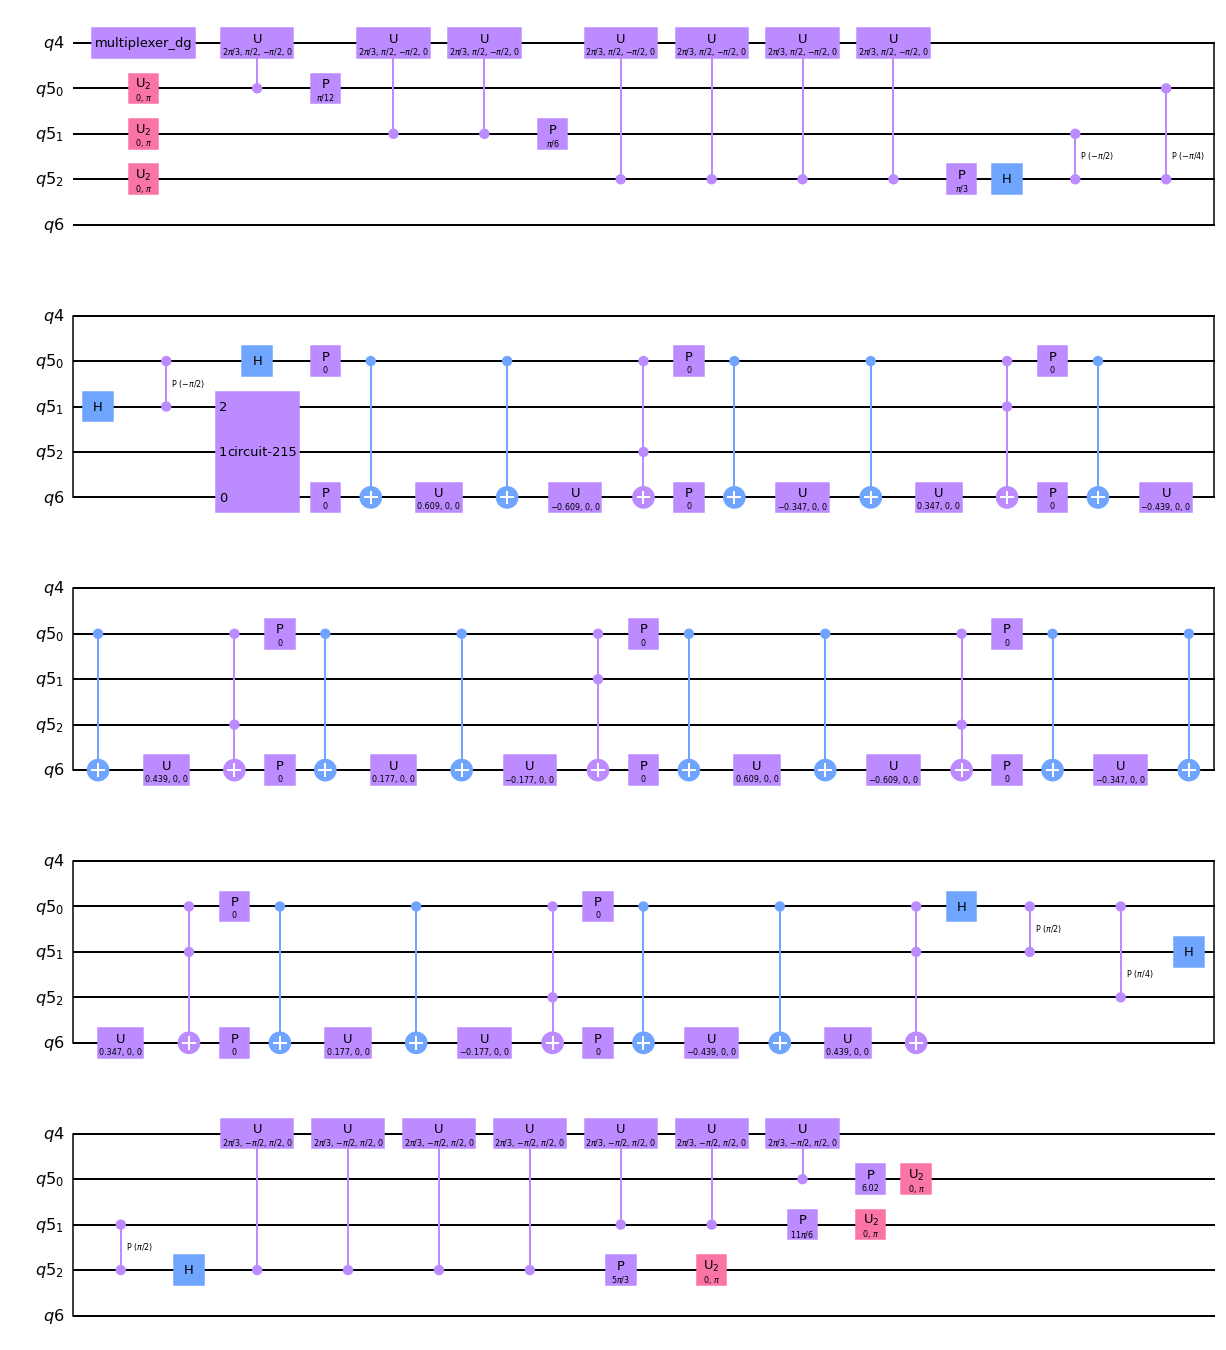

In [11]:
bruh.decompose().decompose().decompose().draw('mpl',scale=1)

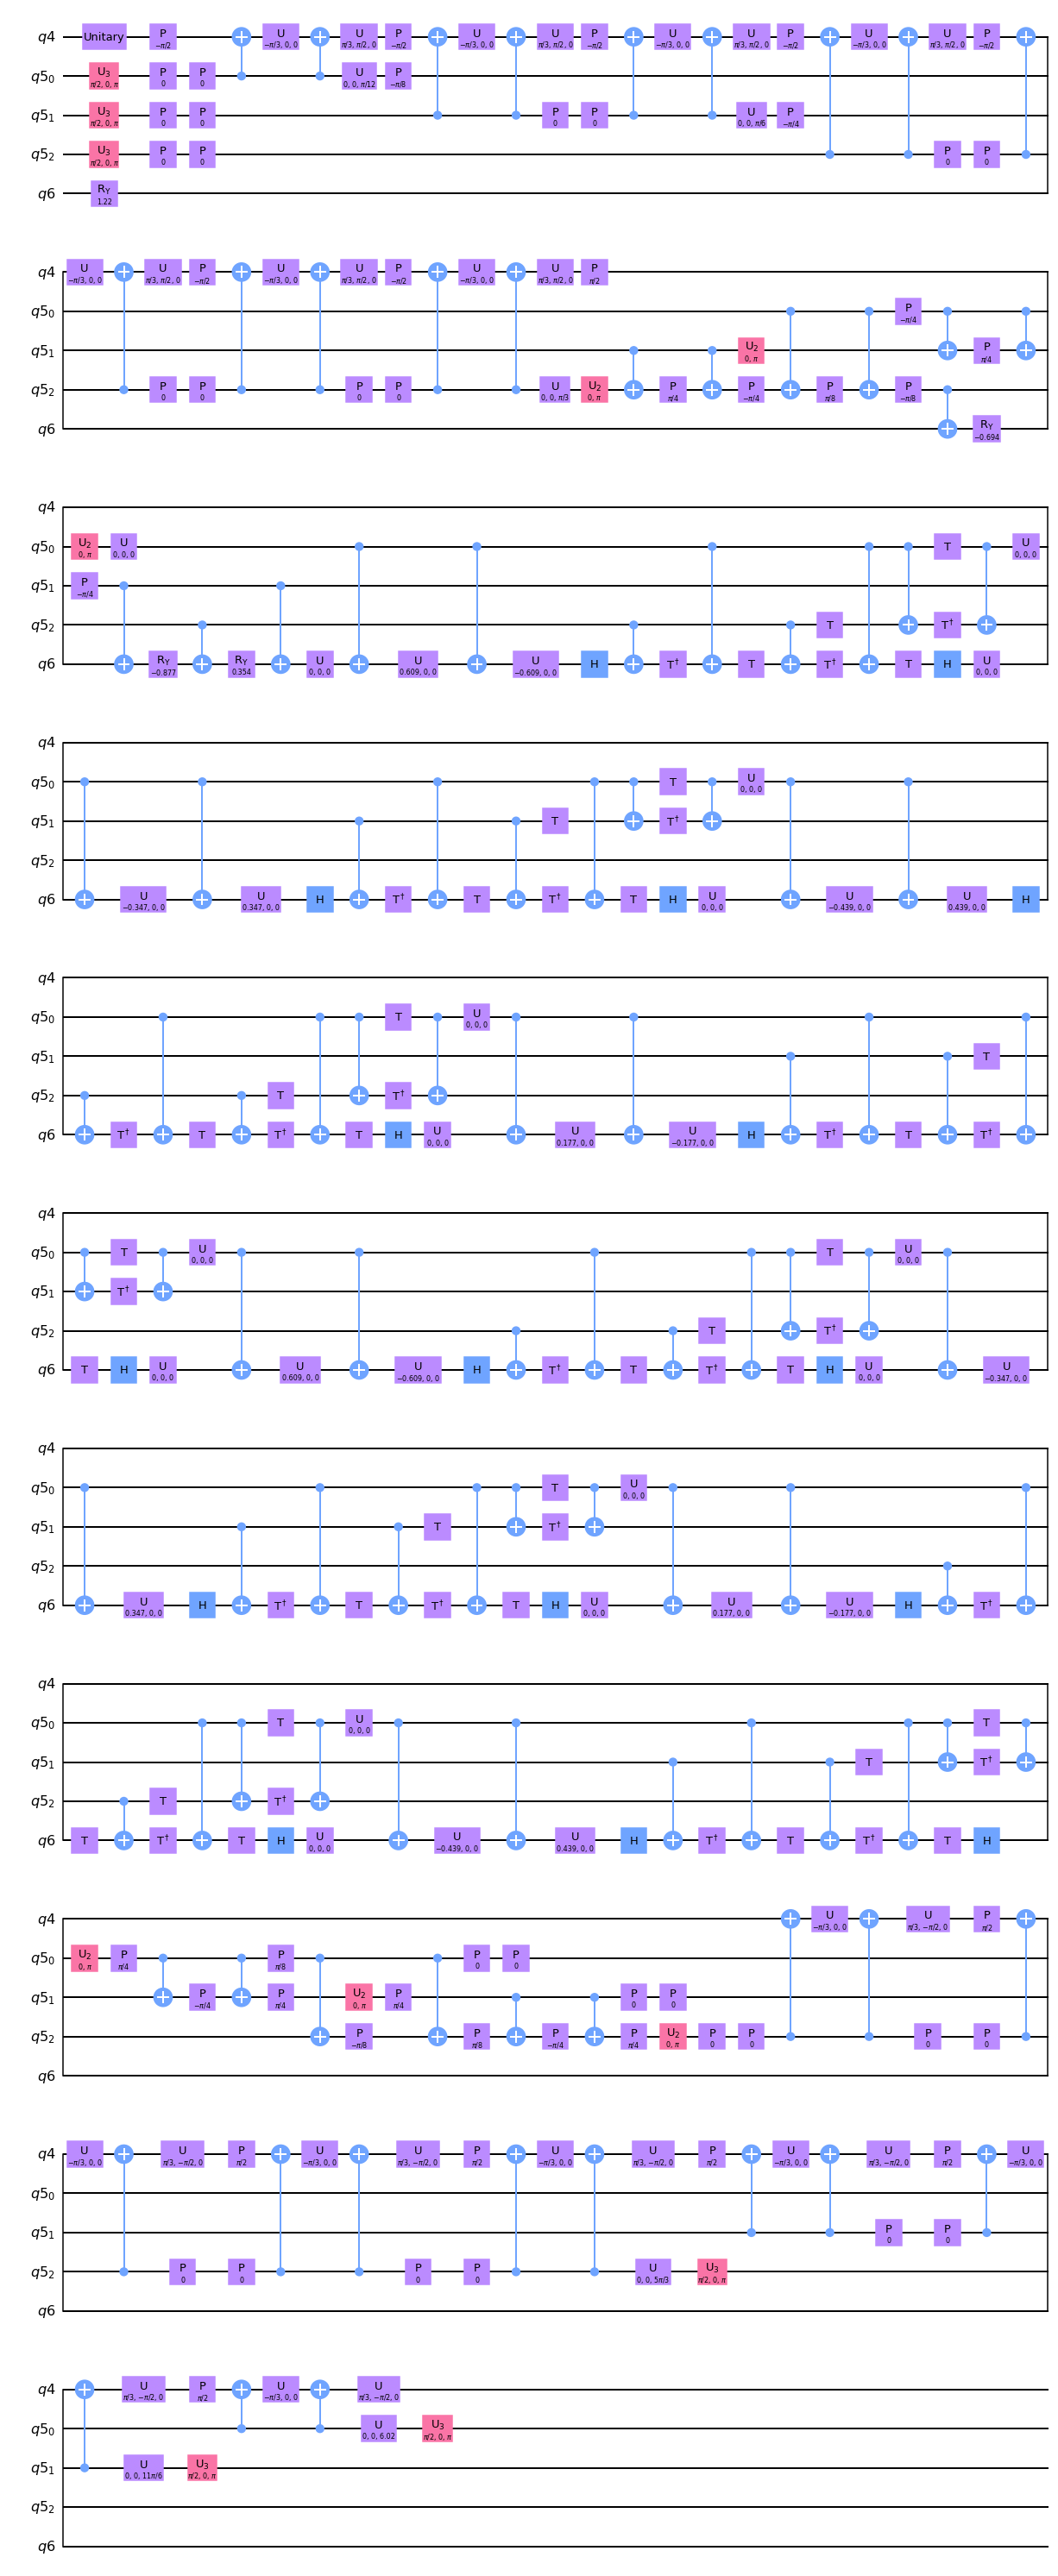

In [15]:
bruh.decompose().decompose().decompose().decompose().draw('mpl',scale=1)

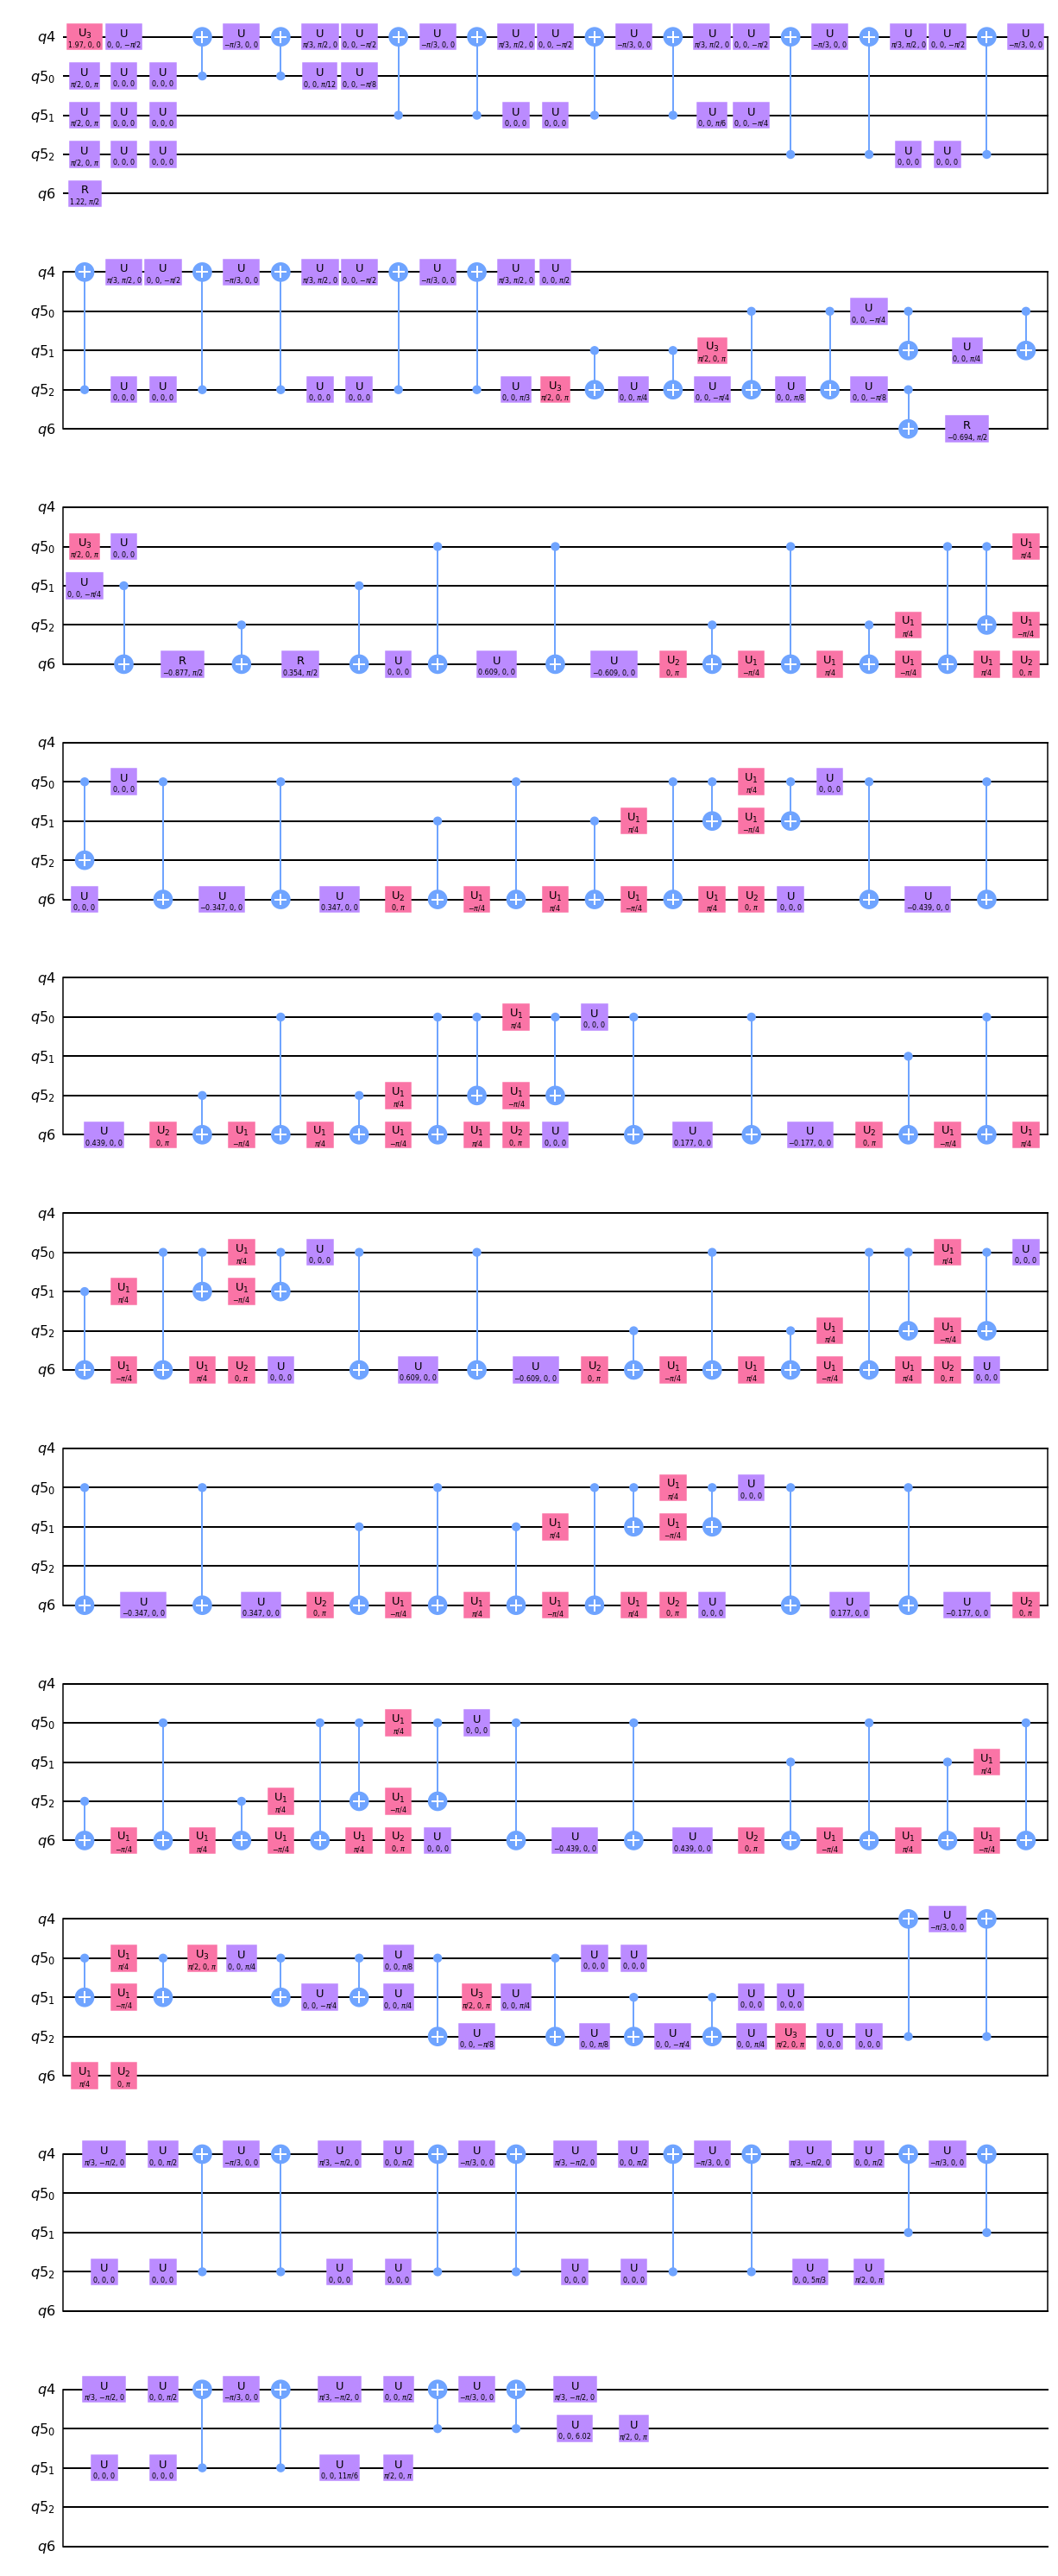

In [17]:
bruh.decompose().decompose().decompose().decompose().decompose().draw('mpl',scale=1)

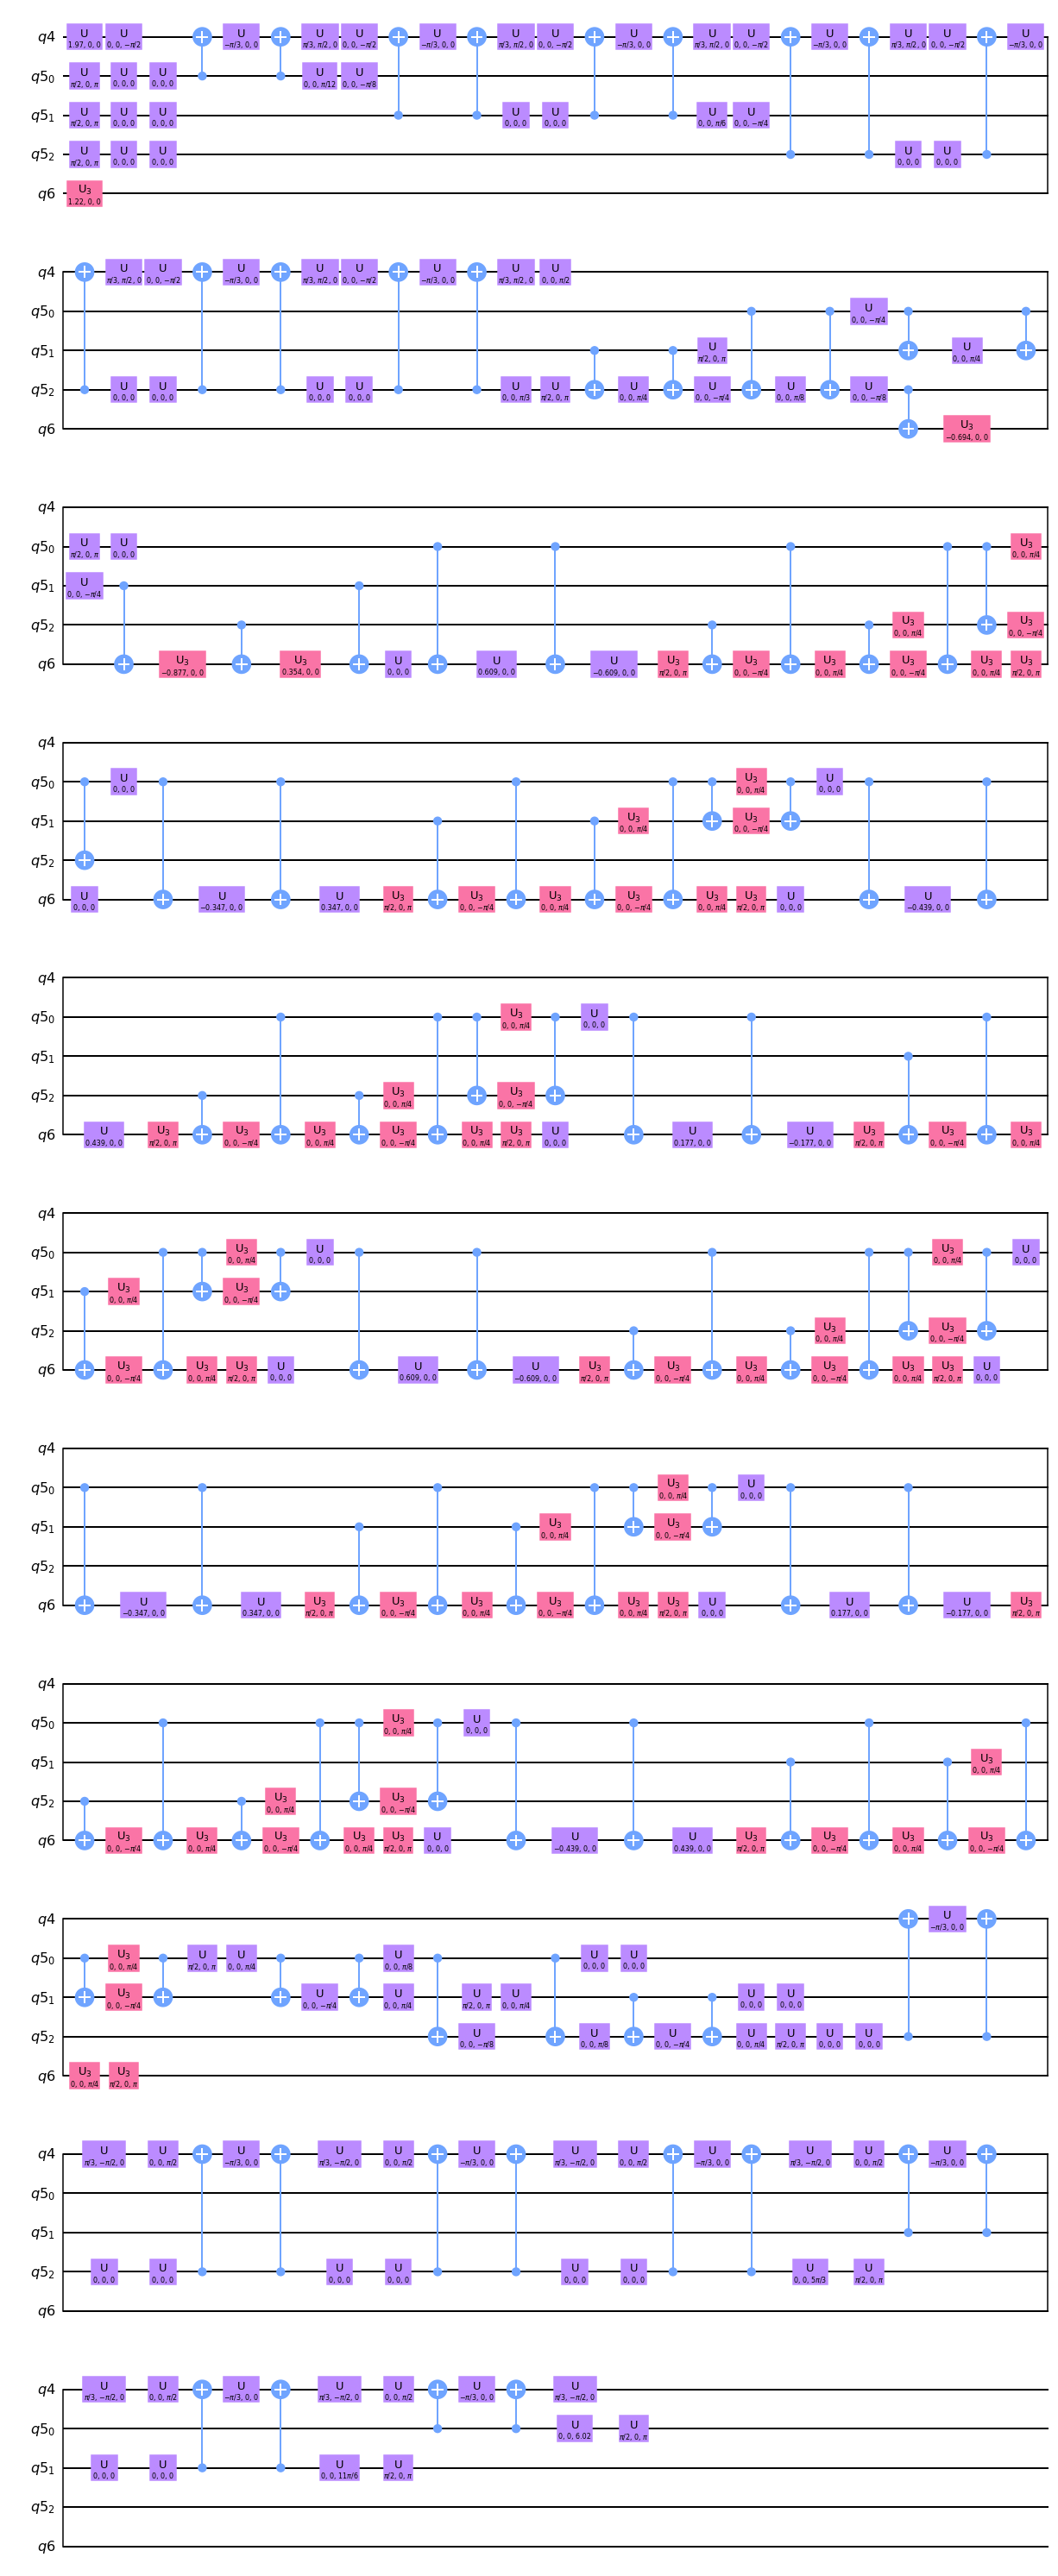

In [18]:
bruh.decompose().decompose().decompose().decompose().decompose().decompose().draw('mpl',scale=1)

In [12]:
print(bruh)

      ┌────────────┐┌──────┐        ┌─────────┐
  q4: ┤ circuit-86 ├┤3     ├────────┤3        ├
      └────────────┘│      │┌──────┐│         │
q5_0: ──────────────┤0     ├┤2     ├┤0        ├
                    │  QPE ││      ││  QPE_dg │
q5_1: ──────────────┤1     ├┤1     ├┤1        ├
                    │      ││  1/x ││         │
q5_2: ──────────────┤2     ├┤0     ├┤2        ├
                    └──────┘│      │└─────────┘
  q6: ──────────────────────┤3     ├───────────
                            └──────┘           


In [20]:
A4 = np.array([[1,0,0,8],[0,1,2,0],[0,2,1,0],[8,0,0,1]])
b4 = np.array([1, 0,0, 0]).T

In [21]:
bruh4 = construct_circuit(A4, b4, True)

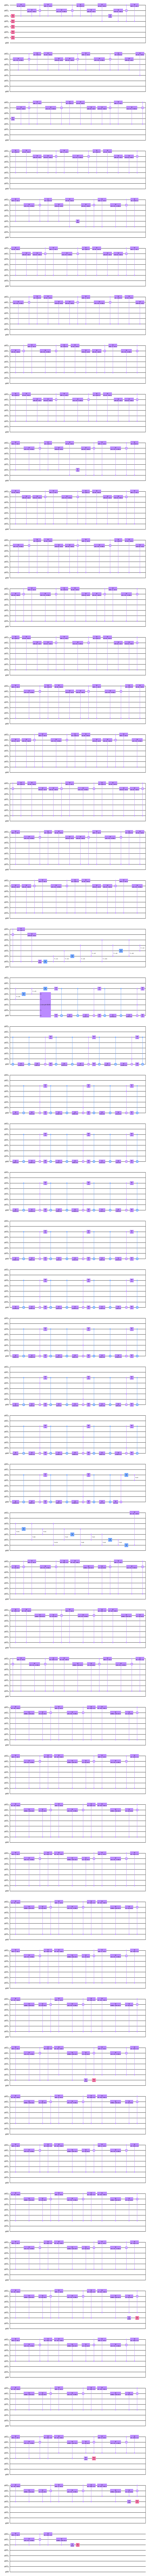

In [26]:
bruh4.decompose().decompose().decompose().draw('mpl',scale=1)

In [ ]:
#.decompose().decompose().decompose().decompose().decompose().decompose()